In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline
import datetime
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
#Считываем данные
raw_df = pd.read_csv('/home/yellow/Загрузки/rosbank_train.csv')
raw_df.head(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
#Нормируем признак amount
scaler = preprocessing.MinMaxScaler()
raw_df['amount'] = scaler.fit_transform(raw_df[['amount']])

In [4]:
raw_df.head(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,0.000140,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,0.000558,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,0.000021,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,0.000057,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,0.001020,C2C_OUT,0,0.0


In [5]:
#Получим информацию о датасете
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


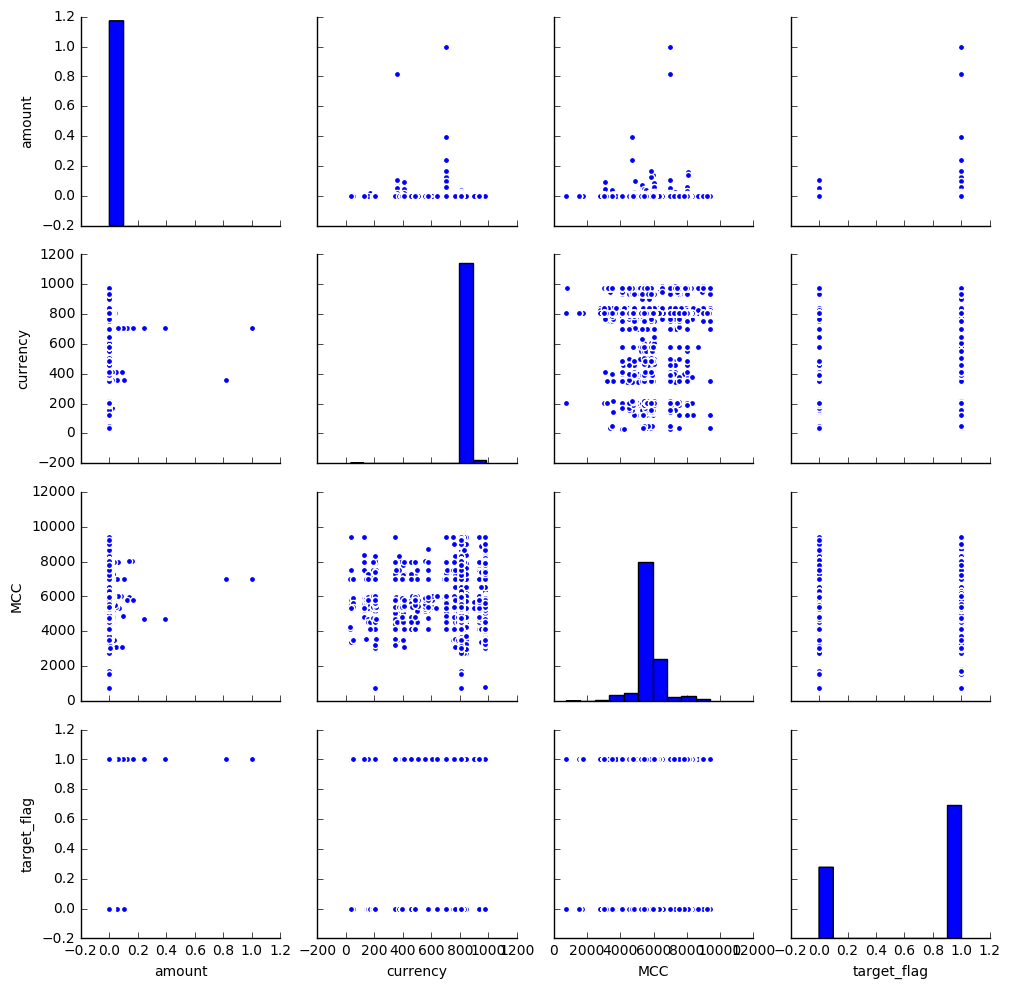

In [6]:
#Посмотрим распределение признаков
sns.pairplot(raw_df,vars=["amount","currency","MCC","target_flag"])
plt.show()

In [7]:
#Найдем самые популярные МСС
raw_df['MCC'].value_counts().head(5)

5411    121640
6011     54382
5814     41351
5812     30027
5499     27237
Name: MCC, dtype: int64

In [8]:
#Найдем самые популярные категории
raw_df['trx_category'].value_counts().head(5)

POS               416425
DEPOSIT            21216
WD_ATM_ROS         19104
WD_ATM_PARTNER      9948
C2C_IN              7306
Name: trx_category, dtype: int64

In [9]:
#Найдем самые популярные валюты
raw_df['currency'].value_counts().head(5)

810    477644
978      5536
840      1921
933       561
985       423
Name: currency, dtype: int64

In [10]:
#Функция для группирокви по дням недели
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df

In [11]:
transaction_by_day_count=transaction_by_day_count(raw_df)

In [12]:
#Изучим информацию о распределении объема транзакций по дням недели
transaction_by_day_count.describe()

day_of_transaction,cl_id,day_0,day_1,day_2,day_3,day_4,day_5,day_6
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,5112.334400,12.422800,13.185400,13.701800,13.897000,14.291600,15.798600,14.805400
std,2977.079513,12.103212,11.580512,11.905462,12.073406,12.247586,13.462507,13.759062
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2537.500000,2.750000,4.000000,4.000000,4.000000,5.000000,5.000000,4.000000
50%,5084.500000,9.000000,11.000000,11.000000,11.000000,12.000000,13.000000,12.000000
75%,7728.000000,19.000000,20.000000,20.000000,21.000000,21.000000,23.000000,22.000000
max,10215.000000,103.000000,116.000000,119.000000,114.000000,111.000000,104.000000,117.000000


Фичами для предсказания возвращения кредита могут быть:
    - кол-во всех транзакций
    - сумму всех транзакций в основных валютах
    - кол-во всех транзакций в выходные

In [14]:
#Функция для кодирования категориальных переменных
def get_one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [15]:
#Функция для определения дня недели транзакции
def day_number(raw_df):
    return raw_df['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 

In [16]:
#Функция для изменения данных
def build_new_columns(data):
    data = get_one_hot(
        raw_df,
        ['MCC', 'trx_category', 'currency']
    )
    data['day_number'] = day_number(raw_df)
    #data['day_part'] = data.apply(lambda row: process_hour(row.hour_key), axis=1)
    #data['week_part'] = data.apply(lambda row: process_day(row.hour_key), axis=1)
    
    return data

In [17]:
data=build_new_columns(raw_df)

In [18]:
#Получим список клиентов
cl_id = data['cl_id'].unique()
new_data = pd.DataFrame(cl_id, columns=['cl_id'])

In [19]:
#Получим первый признак: кол-во всех транзакций
new_data['count_trans']=new_data['cl_id'].apply(lambda x: data[data['cl_id'] ==x]['amount'].count())

In [20]:
#Получим второй признак: сумму всех транзакций в основных валютах
#RUB, UYI, RUB
new_data['sum_810']=new_data['cl_id'].apply(lambda x: data[data['cl_id'] ==x][data['currency'] ==810]['amount'].sum())
new_data['sum_978']=new_data['cl_id'].apply(lambda x: data[data['cl_id'] ==x][data['currency'] ==978]['amount'].sum())
new_data['sum_940']=new_data['cl_id'].apply(lambda x: data[data['cl_id'] ==x][data['currency'] ==940]['amount'].sum())

/home/yellow/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/yellow/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/yellow/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [23]:
#Получим третий признак: кол-во всех транзакций в выходные
new_data['sum_weekwnd']=new_data['cl_id'].apply(lambda x: data[data['cl_id'] ==x][data['day_number']==6]['amount'].sum())

/home/yellow/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [27]:
new_data['target_flag']=new_data['cl_id'].apply(lambda x: data[data['cl_id'] ==x]['target_flag'].max())

In [28]:
new_data.head()

,cl_id,count_trans,sum_810,sum_978,sum_940,sum_weekwnd,target_flag
0,0,5,0.001797,0.000000,0,0,0
1,1,104,0.007442,0.000025,0,0,0
2,5,142,0.015205,0.000001,0,0,1
3,9,39,0.023701,0.000000,0,0,0
4,10,463,0.031375,0.000000,0,0,0


In [31]:
# Клиенты для тестирования
cl_ids_test = np.random.choice(new_data.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [33]:
# Обучающая выборка
data_train = new_data[~new_data.cl_id.isin(cl_ids_test)].copy()
print("Обучающая выборка: ", len(transactions_train))
# Тестовая выборка
data_test = new_data[new_data.cl_id.isin(cl_ids_test)].copy()
print("Тестовая выборка: ", len(transactions_test))

Обучающая выборка:  4000
Тестовая выборка:  1000


In [36]:
train_columns = [
    col for col in data_train.columns.tolist()
    if col not in set(
        [
            'cl_id',
            'target_flag'
        ]
    )
]
x_train = data_train[train_columns]
y_train = data_train['target_flag']
x_test = data_test[train_columns]
y_test = data_test['target_flag']

In [46]:
#xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
xgb = DecisionTreeClassifier()
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  1.0
Test:  0.57


In [ ]:
AUC ROC равен доле пар объектов вида, которые алгоритм верно упорядочил.
Мой AUC ROC маленький=)

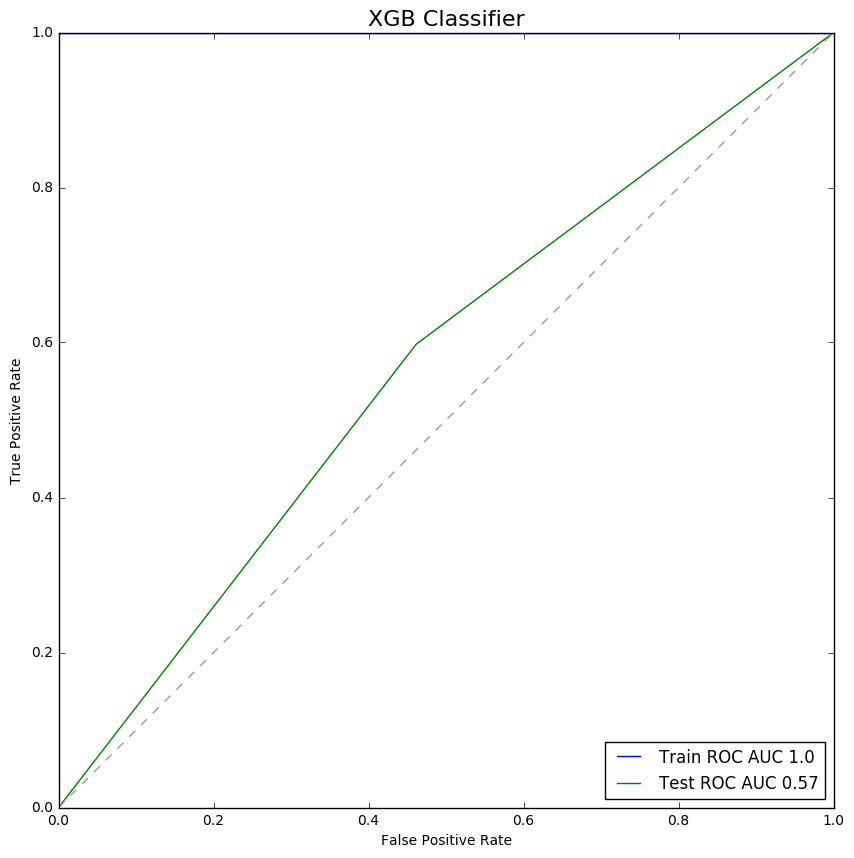

In [47]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()